In [1]:
%pip install snowflake-connector-python pandas numpy lightgbm scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import snowflake.connector
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [3]:
# Fill the placeholders with actual credentials

def connect_snowflake_1():
    try:
       conn = snowflake.connector.connect(
       user='username',
       password="password",
       account='account',  
       warehouse='warehouse_name',
       database='databse_name',
       schema='schema_name',
       role='role'  
       )
       print(" Connection to Snowflake successful!")
       return conn
    except Exception as e:
        print(f"Error connecting to Snowflake: {e}")
        return None

In [ ]:
def query_to_dataframe(query):
    conn = connect_snowflake_1()
    if not conn:
        return None
    try:
        df = pd.read_sql(query, conn)
        print(f" Successfully fetched {len(df):,} rows.")
        return df
    except Exception as e:
        print(f" Query error: {e}")
        return None
    finally:
        conn.close()


query = """
SELECT * FROM UB_PREDICTIVE.TEAM_FALCON.FALCON_SALES_PRED;
"""

df = query_to_dataframe(query)

if df is None or df.empty:
    raise ValueError("No data fetched")


#save to csv file
output_path = "sales_data.csv"
df.to_csv(output_path, index=False)

Loading Data and creating Skeleton Grid...
Final Grid Size: 2,794,392 rows (Continuity Ensured)
Generating Initial HONEST features...
Preparing Hybrid Model Structures...
Training Models...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid_0's quantile: 242.903

STARTING FUTURE PREDICTION LOOP (Ignoring Dec 2025 Actuals in Calc)
Generating Overlaid Plot...


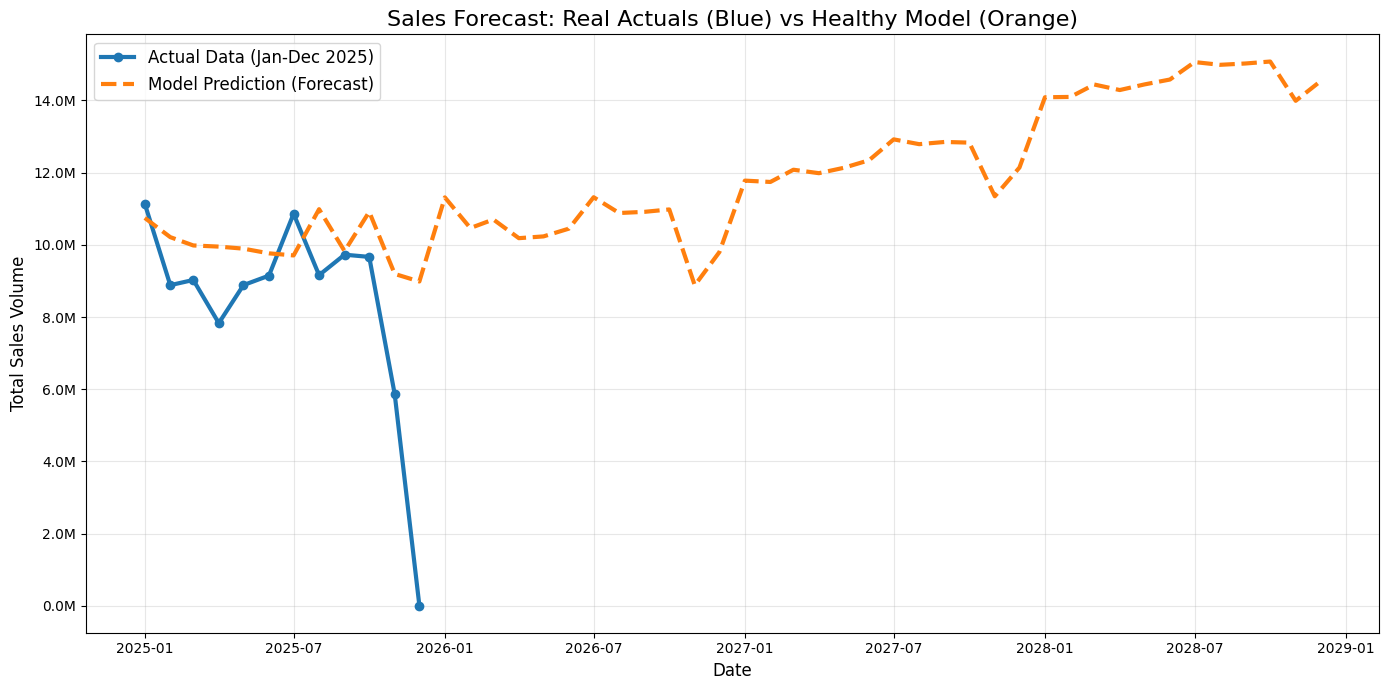

In [6]:
warnings.filterwarnings('ignore')

# ==========================================
# STEP 0: CONFIGURATION
# ==========================================
CONFIG = {
    'TRAIN_END': '2022-12-01',
    'TEST_START': '2023-01-01',
    'EVAL_END': '2025-11-01',
    'FUTURE_YEARS': [2026, 2027, 2028],
    'KEYS': [
        'REGION', 'COUNTRY', 'SALES_ORG', 'FABRIC_TYPE_CLASS',
        'MARKET_SEGMENT', 'GENDER', 'DIVISION_NAME', 'SPORT', 'SILHOUETTE'
    ],
    'TARGET': 'TOTAL_SALES_QTY',
    'DATE_COL': 'MONTH_START'
}

# ==========================================
# STEP 1: LOAD, CLEAN & SKELETON GRID
# ==========================================
print("Loading Data and creating Skeleton Grid...")
df = pd.read_csv('sales_data.csv') 
df[CONFIG['DATE_COL']] = pd.to_datetime(df[CONFIG['DATE_COL']])

# --- CHANGE IS HERE: MERGING CATEGORIES ---
for col in CONFIG['KEYS']:
    if col in df.columns:
        # 1. Fill pure NaNs with 'Others'
        df[col] = df[col].fillna('Others')
        # 2. Replace 'UNKNOWN' and 'NONE' with 'Others'
        #    (We use a dictionary to catch multiple variations safely)
        df[col] = df[col].replace({
            'UNKNOWN': 'Others', 
            'NONE': 'Others', 
            'Unknown': 'Others', 
            'None': 'Others'
        })
# ------------------------------------------

valid_combinations = df[CONFIG['KEYS']].drop_duplicates()
all_dates = pd.DataFrame({
    CONFIG['DATE_COL']: pd.date_range(
        start=df[CONFIG['DATE_COL']].min(),
        end=df[CONFIG['DATE_COL']].max(),
        freq='MS'
    )
})

skeleton = valid_combinations.merge(all_dates, how='cross')
df_agg = df.groupby(CONFIG['KEYS'] + [CONFIG['DATE_COL']])[CONFIG['TARGET']].sum().reset_index()
df_final = pd.merge(skeleton, df_agg, on=CONFIG['KEYS'] + [CONFIG['DATE_COL']], how='left')
df_final[CONFIG['TARGET']] = df_final[CONFIG['TARGET']].fillna(0)

print(f"Final Grid Size: {len(df_final):,} rows (Continuity Ensured)")

# ==========================================
# STEP 2: OUTLIER HANDLING
# ==========================================
train_mask = df_final[CONFIG['DATE_COL']] < CONFIG['TEST_START']
cap_val = df_final.loc[train_mask, CONFIG['TARGET']].quantile(0.999)
df_final[CONFIG['TARGET']] = df_final[CONFIG['TARGET']].clip(upper=cap_val)

# ==========================================
# STEP 3: HONEST FEATURE ENGINEERING
# ==========================================
def generate_features(df_input):
    df_temp = df_input.copy()
    df_temp = df_temp.sort_values(CONFIG['KEYS'] + [CONFIG['DATE_COL']]).reset_index(drop=True)

    df_temp['month'] = df_temp[CONFIG['DATE_COL']].dt.month
    df_temp['year'] = df_temp[CONFIG['DATE_COL']].dt.year
    df_temp['month_sin'] = np.sin(2 * np.pi * df_temp['month'] / 12)
    df_temp['month_cos'] = np.cos(2 * np.pi * df_temp['month'] / 12)

    lags = [12, 13, 14, 24]
    for lag in lags:
        df_temp[f'lag_{lag}'] = df_temp.groupby(CONFIG['KEYS'])[CONFIG['TARGET']].shift(lag)

    for w in [3, 6, 12]:
        df_temp[f'rollmean_{w}_yoy'] = df_temp.groupby(CONFIG['KEYS'])[CONFIG['TARGET']].transform(
            lambda x: x.shift(12).rolling(w).mean()
        )
    return df_temp

print("Generating Initial HONEST features...")
df_final = generate_features(df_final)

# SILHOUETTE PERFORMANCE
train_idx = df_final[CONFIG['DATE_COL']] < '2023-01-01'
sil_stats = df_final[train_idx].groupby('SILHOUETTE')[CONFIG['TARGET']].mean().rename('sil_avg_vol')
df_final = df_final.merge(sil_stats, on='SILHOUETTE', how='left')
df_final['sil_avg_vol'] = df_final['sil_avg_vol'].fillna(0)

df_main_history = df_final.dropna(subset=['lag_24']).copy()
for col in CONFIG['KEYS']:
    df_main_history[col] = df_main_history[col].astype('category')

# ==========================================
# STEP 4: PREPARE FOR HYBRID MODEL
# ==========================================
print("Preparing Hybrid Model Structures...")
df_hybrid = df_main_history[df_main_history[CONFIG['DATE_COL']] <= CONFIG['EVAL_END']].copy()

min_date = df_hybrid[CONFIG['DATE_COL']].min()
def get_trend_index(dates, min_date_ref):
    return ((dates.dt.year - min_date_ref.year) * 12 + 
            (dates.dt.month - min_date_ref.month))

df_hybrid['trend_index'] = get_trend_index(df_hybrid[CONFIG['DATE_COL']], min_date)

train = df_hybrid[df_hybrid[CONFIG['DATE_COL']] < CONFIG['TEST_START']].copy()
test = df_hybrid[df_hybrid[CONFIG['DATE_COL']] >= CONFIG['TEST_START']].copy()

# ==========================================
# STEP 5 & 6: TRAIN MODELS
# ==========================================
print("Training Models...")
X_trend_train = train[['trend_index']].values
X_trend_test = test[['trend_index']].values

lr = LinearRegression()
lr.fit(X_trend_train, train[CONFIG['TARGET']])

train['linear_base'] = lr.predict(X_trend_train)
test['linear_base'] = lr.predict(X_trend_test)

train['residuals'] = train[CONFIG['TARGET']] - train['linear_base']
cols_to_exclude = [CONFIG['TARGET'], CONFIG['DATE_COL'], 'linear_base', 'trend_index', 'residuals']
X_train = train.drop(columns=cols_to_exclude)
cols_to_keep = X_train.columns.tolist()
X_test = test[cols_to_keep]

params = {
    'objective': 'quantile', 'alpha': 0.665, 'metric': 'quantile',
    'learning_rate': 0.05, 'num_leaves': 64, 'bagging_fraction': 0.8,
    'bagging_freq': 5, 'verbose': -1
}

model = lgb.LGBMRegressor(**params, n_estimators=500)
model.fit(X_train, train['residuals'],
          eval_set=[(X_test, test[CONFIG['TARGET']] - test['linear_base'])],
          callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

# ==========================================
# STEP 7: EVALUATE (Through Nov 2025)
# ==========================================
test['pred_residual'] = model.predict(X_test)
test['predicted'] = test['linear_base'] + test['pred_residual']
test['predicted'] = np.maximum(test['predicted'], 0)

# ==========================================
# STEP 8: FUTURE PREDICTION (NUCLEAR OPTION)
# ==========================================
print("\n" + "="*50)
print("STARTING FUTURE PREDICTION LOOP (Ignoring Dec 2025 Actuals in Calc)")
print("="*50)

# 1. We create a calculation dataframe that STOPS at Nov 2025.
#    We DELETE Dec 2025 rows entirely from the model's memory.
df_calc = df_final[df_final[CONFIG['DATE_COL']] <= '2025-11-01'].copy()

for col in CONFIG['KEYS']:
    df_calc[col] = df_calc[col].astype(str)

predictions_storage = []

# 2. We start the loop from 2025 so it RE-PREDICTS Dec 2025 from scratch
future_years = [2025, 2026, 2027, 2028] 
last_actual_date = pd.Timestamp('2025-11-01') # Reset pointer to Nov

for year in future_years:
    # Special handling: For 2025, we only want to predict Dec (after Nov)
    dates_year = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-01', freq='MS')
    dates_df = pd.DataFrame({CONFIG['DATE_COL']: dates_year})
    
    valid_combinations_str = valid_combinations.copy()
    for col in CONFIG['KEYS']:
        valid_combinations_str[col] = valid_combinations_str[col].astype(str)
        
    skeleton_year = valid_combinations_str.merge(dates_df, how='cross')
    skeleton_year[CONFIG['TARGET']] = np.nan
    
    if 'sil_avg_vol' in skeleton_year.columns:
        skeleton_year = skeleton_year.drop(columns=['sil_avg_vol'])
    skeleton_year = skeleton_year.merge(sil_stats, on='SILHOUETTE', how='left')
    skeleton_year['sil_avg_vol'] = skeleton_year['sil_avg_vol'].fillna(0)
    
    # Append skeleton to history
    df_calc = pd.concat([df_calc, skeleton_year], axis=0, ignore_index=True)
    
    # Sort and Deduplicate (Crucial because we might add overlapping months)
    df_calc = df_calc.drop_duplicates(subset=CONFIG['KEYS'] + [CONFIG['DATE_COL']], keep='first')
    df_calc = df_calc.sort_values(CONFIG['KEYS'] + [CONFIG['DATE_COL']]).reset_index(drop=True)

    # Feature Engineering
    df_iter = generate_features(df_calc)

    # Mask: Predict only future
    mask_predict = (df_iter[CONFIG['DATE_COL']].dt.year == year) & (df_iter[CONFIG['DATE_COL']] > last_actual_date)
    
    if not mask_predict.any(): continue 

    df_current_slice = df_iter[mask_predict].copy()

    # Predict
    df_current_slice['trend_index'] = get_trend_index(df_current_slice[CONFIG['DATE_COL']], min_date)
    for col in CONFIG['KEYS']:
        df_current_slice[col] = df_current_slice[col].astype('category')
        
    X_trend = df_current_slice[['trend_index']].values
    df_current_slice['linear_base'] = lr.predict(X_trend)
    X_model = df_current_slice[cols_to_keep] 
    df_current_slice['pred_residual'] = model.predict(X_model)
    df_current_slice['predicted'] = df_current_slice['linear_base'] + df_current_slice['pred_residual']
    df_current_slice['predicted'] = np.maximum(df_current_slice['predicted'], 0)
    
    # Save back to accumulator (This 'predicted' value is now the history for next year!)
    df_calc.loc[mask_predict, CONFIG['TARGET']] = df_current_slice['predicted'].values
    predictions_storage.append(df_current_slice)

df_future_final = pd.concat(predictions_storage)

# ==========================================
# STEP 9: FINAL VISUALIZATION
# ==========================================
print("Generating Overlaid Plot...")

# 1. ACTUALS: Use df_final (Which still has the REAL 0s for Dec 2025)
actuals_plot = df_final[
    (df_final[CONFIG['DATE_COL']].dt.year == 2025)
].groupby(CONFIG['DATE_COL'])[CONFIG['TARGET']].sum().reset_index()

# 2. PREDICTIONS
# Part A: Jan-Nov 2025 (Test Set)
preds_past = test[
    (test[CONFIG['DATE_COL']].dt.year == 2025) & 
    (test[CONFIG['DATE_COL']] <= pd.Timestamp('2025-11-01'))
][[CONFIG['DATE_COL'], 'predicted']].copy()

# Part B: Dec 2025 - 2028 (From our Calculation Loop)
preds_future = df_future_final[[CONFIG['DATE_COL'], 'predicted']].copy()

preds_total = pd.concat([preds_past, preds_future]).groupby(CONFIG['DATE_COL'])['predicted'].sum().reset_index()
preds_total = preds_total.sort_values(CONFIG['DATE_COL'])

# 3. Plot
plt.figure(figsize=(14, 7))

# Actuals (Blue)
plt.plot(actuals_plot[CONFIG['DATE_COL']], actuals_plot[CONFIG['TARGET']], 
         marker='o', markersize=6, linewidth=3, color='#1f77b4', 
         label='Actual Data (Jan-Dec 2025)')

# Predictions (Orange)
plt.plot(preds_total[CONFIG['DATE_COL']], preds_total['predicted'], 
         linestyle='--', linewidth=3, color='#ff7f0e', 
         label='Model Prediction (Forecast)')

plt.title("Sales Forecast: Real Actuals (Blue) vs Healthy Model (Orange)", fontsize=16)
plt.ylabel("Total Sales Volume", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
plt.tight_layout()
plt.show()


GENERATING FORECAST BAR CHARTS (2025-2028)


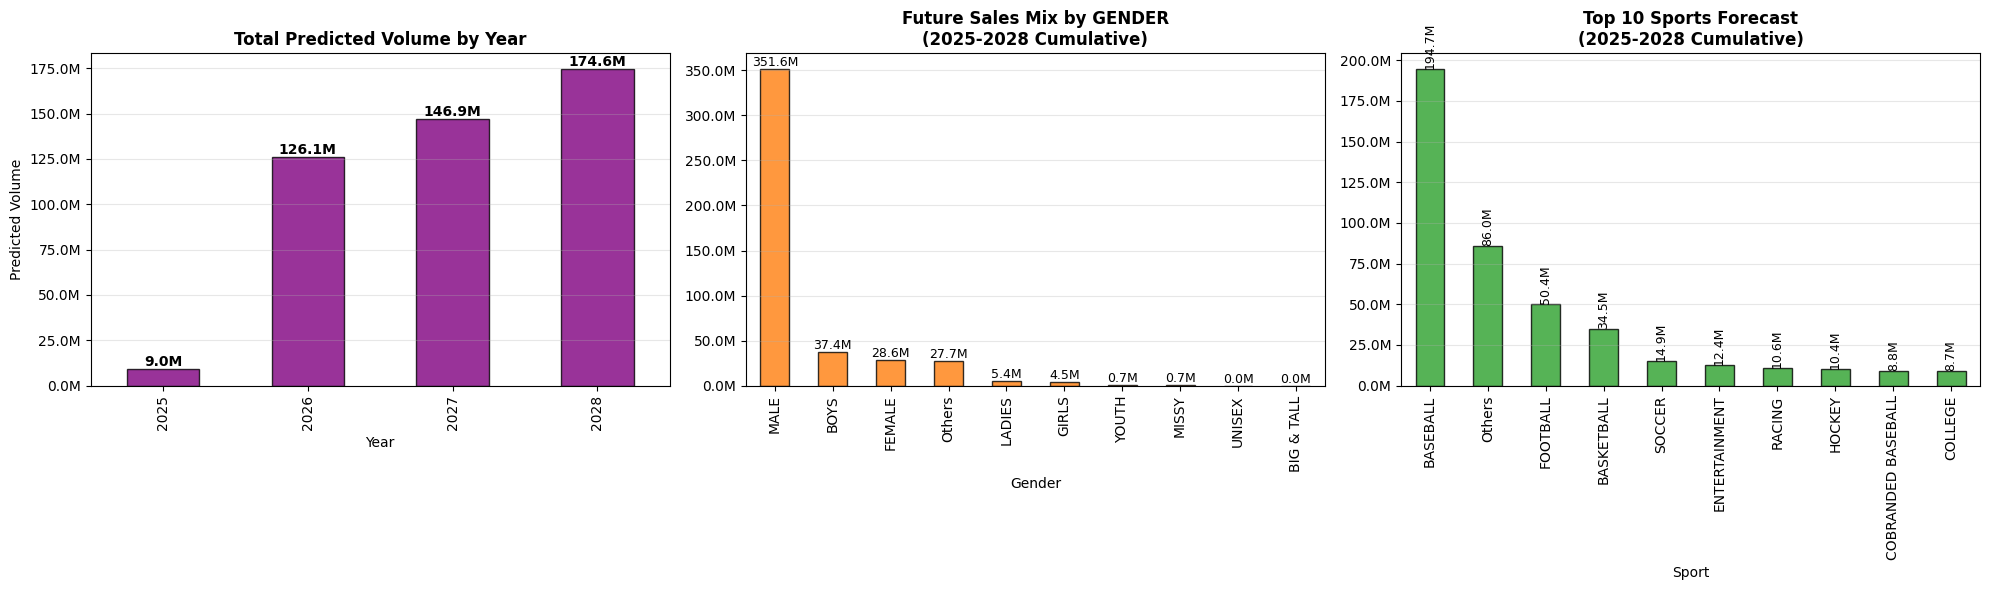

✓ Forecast graphs saved to 'Forecast_Summary_BarCharts.png'


In [7]:
# ==========================================
# STEP 12: VISUALIZE FUTURE FORECASTS (BAR CHARTS)
# ==========================================
print("\n" + "="*50)
print("GENERATING FORECAST BAR CHARTS (2025-2028)")
print("="*50)

# Ensure we are working with the final predictions dataframe
# df_future_final contains predictions for 2025 (re-predicted) + 2026-2028

# 1. PREPARE AGGREGATIONS
# ----------------------------------------
# A. Yearly Total Volume
yearly_forecast = df_future_final.groupby(df_future_final[CONFIG['DATE_COL']].dt.year)['predicted'].sum()

# B. Gender Breakdown (Sum of all future years)
gender_forecast = df_future_final.groupby('GENDER')['predicted'].sum().sort_values(ascending=False)

# C. Sport Breakdown (Sum of all future years)
sport_forecast = df_future_final.groupby('SPORT')['predicted'].sum().sort_values(ascending=False)

# 2. PLOTTING
# ----------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Yearly Forecast ---
yearly_forecast.plot(kind='bar', ax=axes[0], color='purple', edgecolor='black', alpha=0.8)
axes[0].set_title('Total Predicted Volume by Year', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Predicted Volume')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
axes[0].grid(axis='y', alpha=0.3)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()/1e6:.1f}M', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontweight='bold')

# --- Plot 2: Gender Forecast ---
gender_forecast.plot(kind='bar', ax=axes[1], color='#ff7f0e', edgecolor='black', alpha=0.8)
axes[1].set_title('Future Sales Mix by GENDER\n(2025-2028 Cumulative)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
axes[1].grid(axis='y', alpha=0.3)
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()/1e6:.1f}M', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=9)

# --- Plot 3: Sport Forecast ---
# (Limit to Top 10 Sports to avoid clutter)
sport_forecast.head(10).plot(kind='bar', ax=axes[2], color='#2ca02c', edgecolor='black', alpha=0.8)
axes[2].set_title('Top 10 Sports Forecast\n(2025-2028 Cumulative)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sport')
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
axes[2].grid(axis='y', alpha=0.3)
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height()/1e6:.1f}M', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()

# 3. SAVE AND SHOW
plt.savefig('Forecast_Summary_BarCharts.png', dpi=300)
plt.show()

print("✓ Forecast graphs saved to 'Forecast_Summary_BarCharts.png'")